In [ ]:
import torch

In [ ]:
torch.cuda.is_available()

True

In [ ]:
ls

Distillation_basic.ipynb              convnext_model_extended.pth
Swin_t_results.ipynb                  data/
Untitled1.ipynb                       resnet50_baseline.pth
convNext_results.ipynb                swin_distilled.pth
conv_self_kd.pth                      swin_model.pth
convnext_model.pth                    t4_results.txt
convnext_model_baseline.pth           train.csv
convnext_model_baseline_extended.pth  train_images/
convnext_model_before.pth             train_images.zip


In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.model_selection import train_test_split

In [ ]:
import torch
#import torchmetrics
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models

In [ ]:
import pandas as pd
import numpy as np
from skimage import io, transform
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset

In [ ]:
from PIL import Image


In [ ]:
## create a custom class
class RetinopathyDataset(Dataset):
  """ Retinopathy Dataset """
  def __init__(self, csv_file, root_dir, transform=None):
    """
    Arguments:
        csv_file (string): Path to the csv file with labels.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.severity_readings = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor()])

  def __len__(self):
      return len(self.severity_readings)

  def __getitem__(self, idx):
      if torch.is_tensor(idx):
          idx = idx.tolist()

      img_name = os.path.join(self.root_dir, self.severity_readings.iloc[idx, 0]+'.png')
      #image = io.imread(img_name)
      image = Image.open(img_name).convert('RGB')
      rating = self.severity_readings.iloc[idx,1]
      sample = (image,rating)

      if self.transform:
        #image_tensor = torch.tensor(sample[0])
        image = self.transform(image)

      return image,rating


In [ ]:
full_dataset = RetinopathyDataset(csv_file='train.csv', root_dir='train_images/')

# Get indices for train and test sets
indices = list(range(len(full_dataset)))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

# Create training and testing datasets
train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
test_dataset = torch.utils.data.Subset(full_dataset, test_indices)

In [ ]:
len(test_dataset)

733

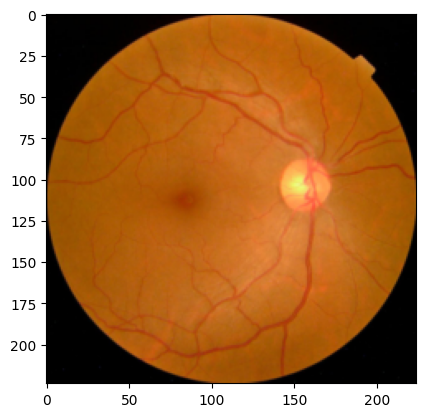

In [ ]:

## sample image from train dataset
image_array = train_dataset[12][0].numpy()

# Transpose the array to match the expected order for image plotting (H, W, C)
image_array = image_array.transpose(1, 2, 0)

# Display the image using Matplotlib
plt.imshow(image_array)
plt.show()

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=64,shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=64,shuffle=False, num_workers=2)

In [ ]:
def test_model(test_model):
  correct_examples = 0
  total_examples = 0
  test_model.eval()

  with torch.no_grad():
      for test_data, test_labels in test_dataloader:
          # Assuming your_model is your trained neural network
          test_data=test_data.to(device)
          test_labels=test_labels.to(device)
          output_predictions = test_model(test_data)

          # Calculate accuracy
          _, predicted = torch.max(output_predictions, 1)
          correct_examples += (predicted == test_labels).sum().item()
          total_examples += test_labels.size(0)

  accuracy = correct_examples / total_examples
  print(f"Accuracy: {accuracy * 100:.2f}%")
  print("\nCorrect:",correct_examples)
  print("\nTotal:",total_examples)


In [ ]:
swin_model = models.swin_t()
swin_model.head = nn.Linear(768,5,bias=True)  ## change the final classifier layer to 5 output features

In [ ]:
swin_model = swin_model.to(device)
optimizer = optim.Adam(swin_model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-02, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

In [ ]:
epochs = 25
train_losses = []
train_accs = []
best_acc = 0
batch = 0
best_val_acc = 0

for epoch in range(epochs):
  correct_examples = 0
  total_examples = 0
  train_loss = 0
  swin_model.train()
  for inputs,targets in train_dataloader:
    inputs = inputs.to(device)
    targets = targets.to(device)
    optimizer.zero_grad()

    model_logits = swin_model(inputs)
    model_predictions = torch.argmax(model_logits,dim=1)
    loss = criterion(model_logits,targets)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    correct_examples += torch.sum((model_predictions==targets))
    total_examples += targets.numel()

  avg_loss = train_loss / len(train_dataloader)
  avg_acc = correct_examples / total_examples
  train_losses.append(avg_loss)
  train_accs.append(avg_acc)


  swin_model.eval()
  with torch.no_grad():
    for inputs,targets in test_dataloader:
      inputs = inputs.to(device)
      targets = targets.to(device)
      optimizer.zero_grad()
      model_logits = swin_model(inputs)
      model_predictions = torch.argmax(model_logits,dim=1)
      correct_examples += torch.sum((model_predictions==targets))
      total_examples += targets.numel()

  avg_val_acc = correct_examples / total_examples
  train_accs.append(avg_val_acc)

  ## save the best model
  if avg_val_acc > best_val_acc:
    best_val_acc = avg_val_acc
    torch.save(swin_model.state_dict(), 'swin_model.pth')
    print('Saving model....')
  print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))
  print("\n Validation accuracy: %.4f" %(avg_val_acc))


Saving model....
Training loss: 1.2481, Training accuracy: 0.4851

 Validation accuracy: 0.4885
Saving model....
Training loss: 1.0556, Training accuracy: 0.5903

 Validation accuracy: 0.6131
Saving model....
Training loss: 0.9149, Training accuracy: 0.6658

 Validation accuracy: 0.6712
Saving model....
Training loss: 0.8627, Training accuracy: 0.6876

 Validation accuracy: 0.6887
Saving model....
Training loss: 0.8525, Training accuracy: 0.6927

 Validation accuracy: 0.6980
Saving model....
Training loss: 0.8282, Training accuracy: 0.7019

 Validation accuracy: 0.7040
Training loss: 0.8326, Training accuracy: 0.6927

 Validation accuracy: 0.6936
Saving model....
Training loss: 0.8011, Training accuracy: 0.7050

 Validation accuracy: 0.7043
Saving model....
Training loss: 0.7976, Training accuracy: 0.7033

 Validation accuracy: 0.7062
Saving model....
Training loss: 0.8040, Training accuracy: 0.7112

 Validation accuracy: 0.7141
Saving model....
Training loss: 0.7811, Training accuracy

In [ ]:
test_model(swin_model)

Accuracy: 72.44%

Correct: 531

Total: 733


CONVNEXT TRAINING

In [ ]:
convnext_model = models.convnext_tiny(weights=None)
convnext_model.classifier[2] = nn.Linear(768,5)  ## change the final layer to 5 features
convnext_model = convnext_model.to(device)
optimizer = optim.Adam(convnext_model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

In [ ]:
#optimizer = optim.Adam(convnext_model.parameters(), lr=0.0006, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
epochs = 68
#train_losses = []
#train_accs = []
best_acc = 0
batch = 0
best_val_acc = 0.7272

for epoch in range(epochs):
  correct_examples = 0
  total_examples = 0
  train_loss = 0
  convnext_model.train()
  for inputs,targets in train_dataloader:
    inputs = inputs.to(device)
    targets = targets.to(device)
    optimizer.zero_grad()

    model_logits = convnext_model(inputs)
    model_predictions = torch.argmax(model_logits,dim=1)
    loss = criterion(model_logits,targets)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    correct_examples += torch.sum((model_predictions==targets))
    total_examples += targets.numel()

  avg_loss = train_loss / len(train_dataloader)
  avg_acc = correct_examples / total_examples
  train_losses.append(avg_loss)
  train_accs.append(avg_acc)


  convnext_model.eval()
  with torch.no_grad():
    for inputs,targets in test_dataloader:
      inputs = inputs.to(device)
      targets = targets.to(device)
      optimizer.zero_grad()
      model_logits = convnext_model(inputs)
      model_predictions = torch.argmax(model_logits,dim=1)
      correct_examples += torch.sum((model_predictions==targets))
      total_examples += targets.numel()

  avg_val_acc = correct_examples / total_examples
  train_accs.append(avg_val_acc)

  ## save the best model
  if avg_val_acc > best_val_acc:
    best_val_acc = avg_val_acc
    torch.save(convnext_model.state_dict(), 'convnext_model.pth')
    print('Saving model....')
  print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))
  print("\n Validation accuracy: %.4f" %(avg_val_acc))


Training loss: 0.7520, Training accuracy: 0.7204

 Validation accuracy: 0.7253
Training loss: 0.7427, Training accuracy: 0.7221

 Validation accuracy: 0.7253
Training loss: 0.7271, Training accuracy: 0.7228

 Validation accuracy: 0.7253
Training loss: 0.7303, Training accuracy: 0.7252

 Validation accuracy: 0.7261
Saving model....
Training loss: 0.7314, Training accuracy: 0.7296

 Validation accuracy: 0.7318
Training loss: 0.7265, Training accuracy: 0.7279

 Validation accuracy: 0.7297
Training loss: 0.7255, Training accuracy: 0.7248

 Validation accuracy: 0.7215
Training loss: 0.7278, Training accuracy: 0.7327

 Validation accuracy: 0.7318
Training loss: 0.7289, Training accuracy: 0.7224

 Validation accuracy: 0.7176
Training loss: 0.7444, Training accuracy: 0.7235

 Validation accuracy: 0.7267
Training loss: 0.7224, Training accuracy: 0.7200

 Validation accuracy: 0.7223
Training loss: 0.7223, Training accuracy: 0.7245

 Validation accuracy: 0.7277
Training loss: 0.7232, Training acc

In [ ]:
test_model(convnext_model)

Accuracy: 74.35%

Correct: 545

Total: 733


BASELINE CONVNEXT ACCURACY

In [ ]:
convnext_model = models.convnext_tiny(weights=None)
convnext_model.classifier[2] = nn.Linear(768,5)
convnext_model = convnext_model.to(device)
optimizer = optim.Adam(convnext_model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer,12,0.1)
criterion = nn.CrossEntropyLoss()

In [ ]:
#optimizer = optim.Adam(convnext_model.parameters(), lr=0.0006, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
epochs = 25
#train_losses = []
#train_accs = []
best_acc = 0
batch = 0
best_val_acc = 0

for epoch in range(epochs):
  correct_examples = 0
  total_examples = 0
  train_loss = 0
  convnext_model.train()
  for inputs,targets in train_dataloader:
    inputs = inputs.to(device)
    targets = targets.to(device)
    optimizer.zero_grad()

    model_logits = convnext_model(inputs)
    model_predictions = torch.argmax(model_logits,dim=1)
    loss = criterion(model_logits,targets)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    correct_examples += torch.sum((model_predictions==targets))
    total_examples += targets.numel()

  avg_loss = train_loss / len(train_dataloader)
  avg_acc = correct_examples / total_examples
  train_losses.append(avg_loss)
  train_accs.append(avg_acc)


  convnext_model.eval()
  with torch.no_grad():
    for inputs,targets in test_dataloader:
      inputs = inputs.to(device)
      targets = targets.to(device)
      optimizer.zero_grad()
      model_logits = convnext_model(inputs)
      model_predictions = torch.argmax(model_logits,dim=1)
      correct_examples += torch.sum((model_predictions==targets))
      total_examples += targets.numel()

  avg_val_acc = correct_examples / total_examples
  train_accs.append(avg_val_acc)

  ## save the best model
  if avg_val_acc > best_val_acc:
    best_val_acc = avg_val_acc
    torch.save(convnext_model.state_dict(), 'convnext_model_baseline.pth')
    print('Saving model....')
  print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))
  print("\n Validation accuracy: %.4f" %(avg_val_acc))


Saving model....
Training loss: 1.6400, Training accuracy: 0.4653

 Validation accuracy: 0.4752
Saving model....
Training loss: 1.1654, Training accuracy: 0.5251

 Validation accuracy: 0.5478
Saving model....
Training loss: 1.0691, Training accuracy: 0.6084

 Validation accuracy: 0.6251
Saving model....
Training loss: 0.9201, Training accuracy: 0.6719

 Validation accuracy: 0.6789
Saving model....
Training loss: 0.8660, Training accuracy: 0.6907

 Validation accuracy: 0.6794
Saving model....
Training loss: 0.8407, Training accuracy: 0.6907

 Validation accuracy: 0.6966
Saving model....
Training loss: 0.8294, Training accuracy: 0.7047

 Validation accuracy: 0.7097
Saving model....
Training loss: 0.8134, Training accuracy: 0.7132

 Validation accuracy: 0.7152
Training loss: 0.8083, Training accuracy: 0.6975

 Validation accuracy: 0.7021
Training loss: 0.7946, Training accuracy: 0.7084

 Validation accuracy: 0.7086
Training loss: 0.8165, Training accuracy: 0.6917

 Validation accuracy: 0.

In [ ]:
convnext_model_baseline = models.convnext_tiny(weights=None)
convnext_model_baseline.classifier[2] = nn.Linear(768,5)
convnext_model_baseline = convnext_model_baseline.to(device)
convnext_model_baseline.load_state_dict(torch.load('convnext_model_baseline.pth'))
test_model(convnext_model_baseline)

Accuracy: 73.94%

Correct: 542

Total: 733


TEACHING CONVNEXT WITH CONVNEXT

In [ ]:
conv_teacher = models.convnext_tiny(weights=None)
conv_teacher.classifier[2] = nn.Linear(768,5)
conv_teacher = conv_teacher.to(device)
conv_teacher.load_state_dict(torch.load('convnext_model_extended.pth'))
test_model(conv_teacher)

Accuracy: 74.35%

Correct: 545

Total: 733


TEACHING SWIN WITH CONVNEXT

In [ ]:
def kd(teacher,student,optimizer,alpha,T,model_path):
  best_val_acc = 0
  train_losses = []
  val_losses = []
  for epoch in range(25):
    print(f'Epoch {epoch}')
    train_loss = 0
    correct_examples = 0
    total_examples = 0
    student.train()
    for inputs, targets in train_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        student_logits = student(inputs)
        teacher_logits = teacher(inputs)

        loss = F.kl_div(F.log_softmax(student_logits / T, dim=1),F.softmax(teacher_logits / T, dim=1),reduction='batchmean')  * alpha + F.cross_entropy(student_logits, targets) * (1 - alpha)
        #loss = alpha*F.cross_entropy(student_logits/T, F.softmax(teacher_logits/T,dim=1))*(T**2) + F.cross_entropy(student_logits, targets)*(1-alpha)
        output_predictions = torch.argmax(student_logits, dim=1)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct_examples += torch.sum((output_predictions == targets))
        total_examples += targets.numel()

    avg_loss = train_loss / len(train_dataloader)
    avg_acc = correct_examples.float() / total_examples
    train_losses.append(avg_loss)

    # Validation process
    student.eval()
    total_examples = 0
    correct_examples = 0
    val_loss = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = student(inputs)
            loss = F.cross_entropy(outputs, targets)

            _, predicted = outputs.max(1)
            total_examples += targets.size(0)
            correct_examples += predicted.eq(targets).sum().item()
            val_loss += loss.item()

    avg_loss = val_loss / len(test_dataloader)
    avg_acc = correct_examples / total_examples
    print(f'Validation loss: {avg_loss:.4f}, Validation accuracy: {avg_acc:.4f}')
    val_losses.append(avg_loss)

    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        print('New best validation accuracy, saving model...')
        torch.save(student.state_dict(), model_path)

    print(f"Training loss: {avg_loss:.4f}, Training accuracy: {avg_acc:.4f}")

  return train_losses,val_losses,student


In [ ]:
swin_model_student = models.swin_t()
swin_model_student.head = nn.Linear(768,5,bias=True)
swin_model_student = swin_model_student.to(device)
optimizer = optim.Adam(swin_model_student.parameters(),lr=0.001,betas=(0.9,0.999),eps=1e-2,weight_decay=1e-5)

In [ ]:
swin_train,swin_val,swin_model_student = kd(conv_teacher,swin_model_student,0.25,11,'swin_distilled.pth')

Epoch 0
Validation loss: 1.3173, Validation accuracy: 0.4789
New best validation accuracy, saving model...
Training loss: 1.3173, Training accuracy: 0.4789
Epoch 1
Validation loss: 1.3070, Validation accuracy: 0.4789
Training loss: 1.3070, Training accuracy: 0.4789
Epoch 2
Validation loss: 1.3569, Validation accuracy: 0.4079
Training loss: 1.3569, Training accuracy: 0.4079
Epoch 3
Validation loss: 1.2436, Validation accuracy: 0.5089
New best validation accuracy, saving model...
Training loss: 1.2436, Training accuracy: 0.5089
Epoch 4
Validation loss: 1.2478, Validation accuracy: 0.4843
Training loss: 1.2478, Training accuracy: 0.4843
Epoch 5
Validation loss: 1.2265, Validation accuracy: 0.5143
New best validation accuracy, saving model...
Training loss: 1.2265, Training accuracy: 0.5143
Epoch 6
Validation loss: 1.2299, Validation accuracy: 0.4789
Training loss: 1.2299, Training accuracy: 0.4789
Epoch 7
Validation loss: 1.1583, Validation accuracy: 0.5266
New best validation accuracy, s

In [ ]:
test_model(swin_model_student)

Accuracy: 73.40%

Correct: 538

Total: 733


CONVNEXT SELF KD

In [ ]:
conv_student = models.convnext_tiny(weights=None)
conv_student.classifier[2] = nn.Linear(768,5)
conv_student = conv_student.to(device)
optimizer = optim.Adam(conv_student.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
#scheduler = optim.lr_scheduler.StepLR(optimizer,12,0.1)
criterion = nn.CrossEntropyLoss()

In [ ]:
convs_train,conv_val,conv_student = kd(conv_teacher,conv_student,optimizer,0.25,11,'conv_self.pth')

Epoch 0
Validation loss: 1.2733, Validation accuracy: 0.5157
New best validation accuracy, saving model...
Training loss: 1.2733, Training accuracy: 0.5157
Epoch 1
Validation loss: 1.1652, Validation accuracy: 0.5798
New best validation accuracy, saving model...
Training loss: 1.1652, Training accuracy: 0.5798
Epoch 2
Validation loss: 1.0355, Validation accuracy: 0.6330
New best validation accuracy, saving model...
Training loss: 1.0355, Training accuracy: 0.6330
Epoch 3
Validation loss: 1.0844, Validation accuracy: 0.6698
New best validation accuracy, saving model...
Training loss: 1.0844, Training accuracy: 0.6698
Epoch 4
Validation loss: 0.8442, Validation accuracy: 0.7326
New best validation accuracy, saving model...
Training loss: 0.8442, Training accuracy: 0.7326
Epoch 5
Validation loss: 0.8457, Validation accuracy: 0.7135
Training loss: 0.8457, Training accuracy: 0.7135
Epoch 6
Validation loss: 0.8620, Validation accuracy: 0.7108
Training loss: 0.8620, Training accuracy: 0.7108


In [ ]:
test_model(conv_student)

Accuracy: 73.40%

Correct: 538

Total: 733


In [ ]:
conv_student_best = models.convnext_tiny(weights=None)
conv_student_best.classifier[2] = nn.Linear(768,5)
conv_student_best = conv_student_best.to(device)
conv_student_best.load_state_dict(torch.load('conv_self.pth'))

<All keys matched successfully>

In [ ]:
test_model(conv_student_best)

Accuracy: 73.53%

Correct: 539

Total: 733


In [ ]:
results = {'swin_train':swin_train,'swin_val':swin_val}
file = open('t4_results.txt','w')
for result in results:
	file.write(str(result)+"\n")
file.close()


TRAIN THE CONVNEXT BASELINE MODEL FOR 25 MORE EPOCHS

In [ ]:
optimizer = optim.Adam(convnext_model_baseline.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer,12,0.1)

In [ ]:
#optimizer = optim.Adam(convnext_model.parameters(), lr=0.0006, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
epochs = 25
#train_losses = []
#train_accs = []
best_acc = 0
batch = 0
best_val_acc = 0.7228  ## continuting the teacher training for another 25 epochs

for epoch in range(epochs):
  correct_examples = 0
  total_examples = 0
  train_loss = 0
  convnext_model_baseline.train()
  for inputs,targets in train_dataloader:
    inputs = inputs.to(device)
    targets = targets.to(device)
    optimizer.zero_grad()

    model_logits = convnext_model_baseline(inputs)
    model_predictions = torch.argmax(model_logits,dim=1)
    loss = criterion(model_logits,targets)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    correct_examples += torch.sum((model_predictions==targets))
    total_examples += targets.numel()

  avg_loss = train_loss / len(train_dataloader)
  avg_acc = correct_examples / total_examples
  train_losses.append(avg_loss)
  train_accs.append(avg_acc)


  convnext_model_baseline.eval()
  with torch.no_grad():
    for inputs,targets in test_dataloader:
      inputs = inputs.to(device)
      targets = targets.to(device)
      optimizer.zero_grad()
      model_logits = convnext_model_baseline(inputs)
      model_predictions = torch.argmax(model_logits,dim=1)
      correct_examples += torch.sum((model_predictions==targets))
      total_examples += targets.numel()

  avg_val_acc = correct_examples / total_examples
  train_accs.append(avg_val_acc)

  ## save the best model
  if avg_val_acc > best_val_acc:
    best_val_acc = avg_val_acc
    torch.save(convnext_model_baseline.state_dict(), 'convnext_model_baseline_extended.pth')
    print('Saving model....')
  print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))
  print("\n Validation accuracy: %.4f" %(avg_val_acc))

Saving model....
Training loss: 0.7438, Training accuracy: 0.7245

 Validation accuracy: 0.7269
Saving model....
Training loss: 0.7365, Training accuracy: 0.7293

 Validation accuracy: 0.7297
Training loss: 0.7373, Training accuracy: 0.7252

 Validation accuracy: 0.7275
Training loss: 0.7339, Training accuracy: 0.7252

 Validation accuracy: 0.7277
Saving model....
Training loss: 0.7326, Training accuracy: 0.7282

 Validation accuracy: 0.7305
Training loss: 0.7300, Training accuracy: 0.7286

 Validation accuracy: 0.7305
Saving model....
Training loss: 0.7296, Training accuracy: 0.7279

 Validation accuracy: 0.7310
Saving model....
Training loss: 0.7283, Training accuracy: 0.7303

 Validation accuracy: 0.7329
Training loss: 0.7301, Training accuracy: 0.7272

 Validation accuracy: 0.7307
Training loss: 0.7284, Training accuracy: 0.7235

 Validation accuracy: 0.7288
Training loss: 0.7248, Training accuracy: 0.7293

 Validation accuracy: 0.7291
Training loss: 0.7297, Training accuracy: 0.72

In [ ]:
test_model(convnext_model_baseline)

Accuracy: 74.35%

Correct: 545

Total: 733
